### Losset DYN - calculate DR indicator (dynamical part only)

In [1]:
import os
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import sys
import datetime as dt
import matplotlib.pyplot as plt
%xmode Plain

Exception reporting mode: Plain


In [21]:
kscale_levs = [100,150,200,250,300,400,500,600,700,850,925,1000]
# Variable read in for K-Scale
data_dir = '/gws/nopw/j04/kscale/DATA/outdir_20160801T0000Z/DMn1280GAL9/channel_n2560_RAL3p2/'

# data source, grid res, time
fname_str = "kscaleRAL3n2560_0p5_DS_20160801"

ds_uvw = []
for lev in kscale_levs:
    _ds_uvw = xr.open_mfdataset(
        os.path.join(data_dir,f'profile_{lev}/',f'20160909_20160801T0000Z_channel_profile_3hourly_{lev}_05deg.nc')
    )
    _ds_uvw = _ds_uvw.drop_vars(["longitude_bnds","latitude_bnds","latitude_longitude"])
    _ds_uvw = _ds_uvw.expand_dims(dim={"level": [lev]},axis=3)
    ds_uvw.append(_ds_uvw)

ds_uvw = xr.concat(ds_uvw, dim="level")
# ds_uvw = ds_uvw.isel(time=slice(0,4))
ds_uvw = ds_uvw.transpose("time", "level", "latitude", "longitude")
print(ds_uvw)

lon     = ds_uvw.variables['longitude'][:]
lat     = ds_uvw.variables['latitude'][:]
lev     = ds_uvw.variables['level'][:]
time    = ds_uvw.variables['time'][:]
time    = time

print('lon lat time loaded')

<xarray.Dataset> Size: 257MB
Dimensions:                  (time: 8, latitude: 133, longitude: 720, level: 12)
Coordinates:
  * level                    (level) int64 96B 100 150 200 250 ... 850 925 1000
  * time                     (time) datetime64[ns] 64B 2016-09-09T03:00:00 .....
  * latitude                 (latitude) float64 1kB -40.0 -39.5 ... 25.5 26.0
  * longitude                (longitude) float64 6kB -180.0 -179.5 ... 179.5
    forecast_period          (time) timedelta64[ns] 64B 39 days 03:00:00 ... ...
    forecast_reference_time  datetime64[ns] 8B 2016-08-01
    pressure                 (level) float32 48B 100.0 150.0 ... 925.0 1e+03
Data variables:
    air_temperature          (time, level, latitude, longitude) float32 37MB dask.array<chunksize=(8, 1, 133, 720), meta=np.ndarray>
    geopotential_height      (time, level, latitude, longitude) float32 37MB dask.array<chunksize=(8, 1, 133, 720), meta=np.ndarray>
    relative_humidity        (time, level, latitude, longitude)

In [23]:
u = ds_uvw['x_wind']
v = ds_uvw['y_wind']
w = ds_uvw['upward_air_velocity']
print('kscale u v w loaded (m/s)')

kscale u v w loaded (m/s)


In [3]:
# function to sort out dims
def rename_dims(ds):    
    try:
        ds = ds.rename({'lon':'longitude'})
    except:
        pass
    try:
        ds = ds.rename({'lat':'latitude'})
    except:
        pass
    try:
        ds = ds.rename({'pressure_level':'level'})
    except:
        pass
    try:
        ds = ds.rename({'valid_time':'time'})
    except:
        pass
        
    return ds

In [4]:
year = 2016
month = 8
day = 2
date = f'{year:04d}-{month:02d}-{day:02d}'
data_dir = '/gws/nopw/j04/kscale/USERS/dship/ERA5/3hourly/'
fname_str = f'era5_{date}'
ds_u    = xr.open_dataset(os.path.join(data_dir, f'era5_u_component_of_wind_{year:04d}{month:02d}_3h_0p5deg.nc'))
ds_v = xr.open_dataset(os.path.join(data_dir, f'era5_v_component_of_wind_{year:04d}{month:02d}_3h_0p5deg.nc'))
ds_omega = xr.open_dataset(os.path.join(data_dir, f'era5_vertical_velocity_{year:04d}{month:02d}_3h_0p5deg.nc'))
ds_T = xr.open_dataset(os.path.join(data_dir, f'era5_temperature_{year:04d}{month:02d}_3h_0p5deg.nc'))
# ds_q = xr.open_dataset(os.path.join(data_dir,f'era5_specific_humidity_{year:04d}{month:02d}_3h_0p5deg.nc'))

ds_u = rename_dims(ds_u)
ds_v = rename_dims(ds_v)
ds_omega = rename_dims(ds_omega)
ds_T = rename_dims(ds_T)
# ds_q = rename_dims(ds_q)

lon     = ds_u.variables['longitude'][:]
lat     = ds_u.variables['latitude'][:]
lev     = ds_u.variables['level'][:]
time    = ds_u.variables['time'][:]
# print(time)
# sys.exit()
p = xr.DataArray(
    dims = {'level':lev.data},
    data = lev.data,
    attrs = {'units': 'hPa'}
)

# fix time coordinates
fix_time_coord = False
if fix_time_coord:
    start = dt.datetime(year,month,1,3)
    times = np.array([start + i*dt.timedelta(hours=3) for i in range(len(time))])
    
    ds_u = ds_u.assign_coords({"time": times})
    ds_v = ds_v.assign_coords({"time": times})
    ds_omega = ds_omega.assign_coords({"time": times})

# Read u, v, and omega data
u = ds_u['u']
u = u.sel(time=date)
v = ds_v['v']
v = v.sel(time=date)
omega = ds_omega['w']  # ERA5 'w' is in Pa s**-1 !!!
omega = omega.sel(time=date)
# q = ds_q['q']
# q = q.sel(time=date)

In [5]:
temp = ds_T['t']
temp = temp.sel(time=date)

In [6]:
# Calculate density
rgas = 287.05
g    = 9.81
rho = ((p*100) / (rgas * temp))
rho = rho.transpose('time','level','latitude','longitude')
# print(rho)
# print(omega)

# Calculate w from omega for ERA5
w = np.divide(-omega,(rho*g))

In [7]:
w_wrong = -omega / (0.5 * g)
w_old = omega * -g * 0.5

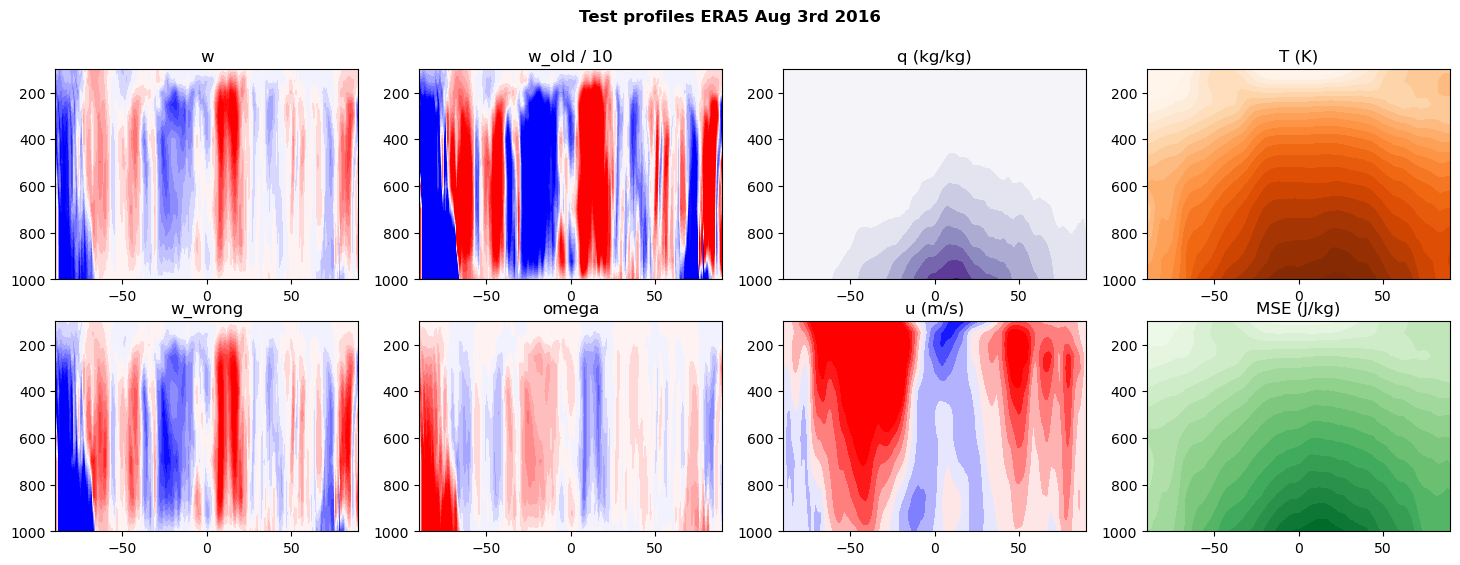

In [62]:
w_wrong_profile_eq = w_wrong.mean(dim=['time','longitude'])
w_old_profile_eq   = w_old.mean(dim=['time','longitude'])
w_profile_eq       = w.mean(dim=['time','longitude'])
omega_profile_eq   = omega.mean(dim=['time','longitude'])
q_profile_eq       = q.mean(dim=['time','longitude'])
u_profile_eq       = u.mean(dim=['time','longitude'])
temp_profile          = temp.mean(dim=['time','longitude'])

c_p = 1000
L = 2.268e6

MSE = c_p * temp + L * q

MSE_profile = MSE.mean(dim=['time','longitude'])

fig,ax = plt.subplots(2,4,figsize=(18,6))

CS = ax[0,0].contourf(lat,p,w_profile_eq,cmap='bwr',levels=np.linspace(-0.01,0.01,21),extend='both')
ax[0,0].set_title('w')
ax[0,0].invert_yaxis()
ax[0,1].contourf(lat,p,w_old_profile_eq/10,cmap='bwr',levels=np.linspace(-0.01,0.01,21),extend='both')
ax[0,1].set_title('w_old / 10')
ax[0,1].invert_yaxis()
ax[1,0].contourf(lat,p,w_wrong_profile_eq,cmap='bwr',levels=np.linspace(-0.01,0.01,21),extend='both')
ax[1,0].set_title('w_wrong')
ax[1,0].invert_yaxis()
ax[1,1].contourf(lat,p,omega_profile_eq,cmap='bwr',levels=np.linspace(-0.1,0.1,21),extend='both')
ax[1,1].set_title('omega')
ax[1,1].invert_yaxis()
Cq = ax[0,2].contourf(lat,p,q_profile_eq,cmap='Purples')
# plt.colorbar(Cq)
ax[0,2].set_title('q (kg/kg)')
ax[0,2].invert_yaxis()
ax[1,2].contourf(lat,p,u_profile_eq,cmap='bwr',levels=np.linspace(-15,15,11),extend='both')
ax[1,2].invert_yaxis()
ax[1,2].set_title('u (m/s)')

ax[0,3].contourf(lat,p,temp_profile,cmap='Oranges',levels=np.linspace(200,300,21),extend='both')
ax[0,3].invert_yaxis()
ax[0,3].set_title('T (K)')

ax[1,3].contourf(lat,p,MSE_profile,cmap='Greens',levels=np.linspace(1.8e5,3.6e5,21),extend='both')
ax[1,3].invert_yaxis()
ax[1,3].set_title('MSE (J/kg)')
# plt.colorbar(CS)

plt.suptitle('Test profiles ERA5 Aug 3rd 2016',fontweight='bold')
# plt.savefig('/home/users/emg97/emgPlots/LO_ERA5_8panel_testvars.png',dpi=600)

Select length scale $\ell_{\mathrm{max}}$

In [7]:
Nlmax = 5

In [8]:
# Dimensions
nt = len(time)
nz = len(lev)
ny = len(lat)
nx = len(lon)

In [9]:
# Horizontal (dR) and vertical (dZ) grid step in m.
dR = abs((lon[0] - lon[1]) * 110000)
dZ = 400  # Suggests interp to 400m grid spacing required

# Horizontal size of the domain
lbox = abs((lon[-1] - lon[0]) * 110000)
# dR

Check for any changes to scripts:

In [10]:
%reload_ext autoreload
%autoreload 2

Run $\verb|CalcPartitionIncrement.py|$

In [11]:
from CalcPartitionIncrement import CalcPartitionIncrement
dR, Nlmax, nphiinc, llx, lly, philsmooth, Nls = CalcPartitionIncrement(dR,Nlmax)

Run $\verb|CalcDRDir_2D.py|$

In [ ]:
from CalcDRDir_2D import CalcDRDir_2D
CalcDRDir_2D(dR, Nlmax, u, v, w, nphiinc, llx, lly, philsmooth, Nls,fname_str,verbose=True)

ntm:  24
Average 0 done
ntm:  36
Average 1 done
ntm:  50
